# Challenge: Boston Marathon

Determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. 

Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth

raw_data = pd.read_csv("./boston_2013.csv")
print(raw_data.shape[0], 'rows;', raw_data.shape[1], 'columns')
raw_data.head()

16164 rows; 21 columns


,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [65]:
df = raw_data.drop(columns=['name', 'division', 'bib', 'ctz', 'state' , 'city', 'genderdiv'], axis=1)

def assign_continent(country):
    if country in ['CAN', 'USA', 'MEX', 'BER', 'CRC', 'DOM', 'BAH', 'PAN', 'CAY', 'ESA', 'VGB', 'TCA']:
        return 'N. America'
    elif country in ['KEN', 'ETH', 'RSA']:
        return 'Africa'
    elif country in ['ECU', 'GUA', 'BRA', 'VEN', 'COL', 'PER', 'CHI', 'ARG', 'URU', 'TRI', 'ARU', 'BOL']:
        return 'S. America'
    elif country in ['JPN', 'HKG', 'KOR', 'SIN', 'CHN', 'UAE', 'ISR', 'TWN', 'IND', 'MAS', 'PHI', 'QAT']:
        return 'Asia'
    elif country in ['AUS', 'NZL']:
        return 'Oceania'
    else:
        return 'Europe'
    
df['continent'] = df['country'].apply(assign_continent)
df = df.drop(columns=['country'])
df.head()

,25k,age,10k,gender,half,official,overall,pace,30k,5k,20k,35k,40k,continent
0,49.87,28,18.18,M,40.93,90.90,9,3.47,62.07,8.90,38.80,74.73,85.55,N. America
1,77.27,30,30.90,M,64.90,132.50,5,5.07,92.97,15.90,61.52,108.78,124.77,Africa
2,77.23,23,30.90,M,64.92,130.37,1,4.98,92.72,15.93,61.53,108.68,123.78,Africa
3,50.50,32,18.73,M,42.00,88.43,5,3.38,61.35,8.98,39.88,73.00,83.43,Oceania
4,48.75,39,18.18,M,40.57,87.22,3,3.33,59.92,8.92,38.55,71.68,81.88,Asia


In [66]:
gender_contin_cols = ['gender', 'continent']
gender_contin_dummies = pd.get_dummies(df[gender_contin_cols])
df = pd.concat([df[df.columns.difference(gender_contin_cols)], gender_contin_dummies], axis=1)

df.head()

,10k,20k,25k,30k,35k,40k,5k,age,half,official,overall,pace,gender_F,gender_M,continent_Africa,continent_Asia,continent_Europe,continent_N. America,continent_Oceania,continent_S. America
0,18.18,38.80,49.87,62.07,74.73,85.55,8.90,28,40.93,90.90,9,3.47,0,1,0,0,0,1,0,0
1,30.90,61.52,77.27,92.97,108.78,124.77,15.90,30,64.90,132.50,5,5.07,0,1,1,0,0,0,0,0
2,30.90,61.53,77.23,92.72,108.68,123.78,15.93,23,64.92,130.37,1,4.98,0,1,1,0,0,0,0,0
3,18.73,39.88,50.50,61.35,73.00,83.43,8.98,32,42.00,88.43,5,3.38,0,1,0,0,0,0,1,0
4,18.18,38.55,48.75,59.92,71.68,81.88,8.92,39,40.57,87.22,3,3.33,0,1,0,1,0,0,0,0


In [67]:
cols_to_norm = ['10k', '20k', '25k', '30k', '35k', '40k', '5k', 'age', 'half', 'official', 'overall', 'pace']

for col_to_norm in cols_to_norm:
    df[col_to_norm] = pd.to_numeric(df[col_to_norm], errors='coerce')

df = df.dropna(subset=cols_to_norm)
# Min Max Scaler instead?
# df[cols_to_norm] = normalize(df[cols_to_norm])
df = pd.concat([df[cols_to_norm], df[df.columns.difference(cols_to_norm)]], axis=1)

print(df.shape[0], 'rows;', df.shape[1], 'columns')

df.head()

16054 rows; 20 columns


,10k,20k,25k,30k,35k,40k,5k,age,half,official,overall,pace,continent_Africa,continent_Asia,continent_Europe,continent_N. America,continent_Oceania,continent_S. America,gender_F,gender_M
0,18.18,38.80,49.87,62.07,74.73,85.55,8.90,28,40.93,90.90,9,3.47,0,0,0,1,0,0,0,1
1,30.90,61.52,77.27,92.97,108.78,124.77,15.90,30,64.90,132.50,5,5.07,1,0,0,0,0,0,0,1
2,30.90,61.53,77.23,92.72,108.68,123.78,15.93,23,64.92,130.37,1,4.98,1,0,0,0,0,0,0,1
3,18.73,39.88,50.50,61.35,73.00,83.43,8.98,32,42.00,88.43,5,3.38,0,0,0,0,1,0,0,1
4,18.18,38.55,48.75,59.92,71.68,81.88,8.92,39,40.57,87.22,3,3.33,0,1,0,0,0,0,0,1


## Data Visualizations

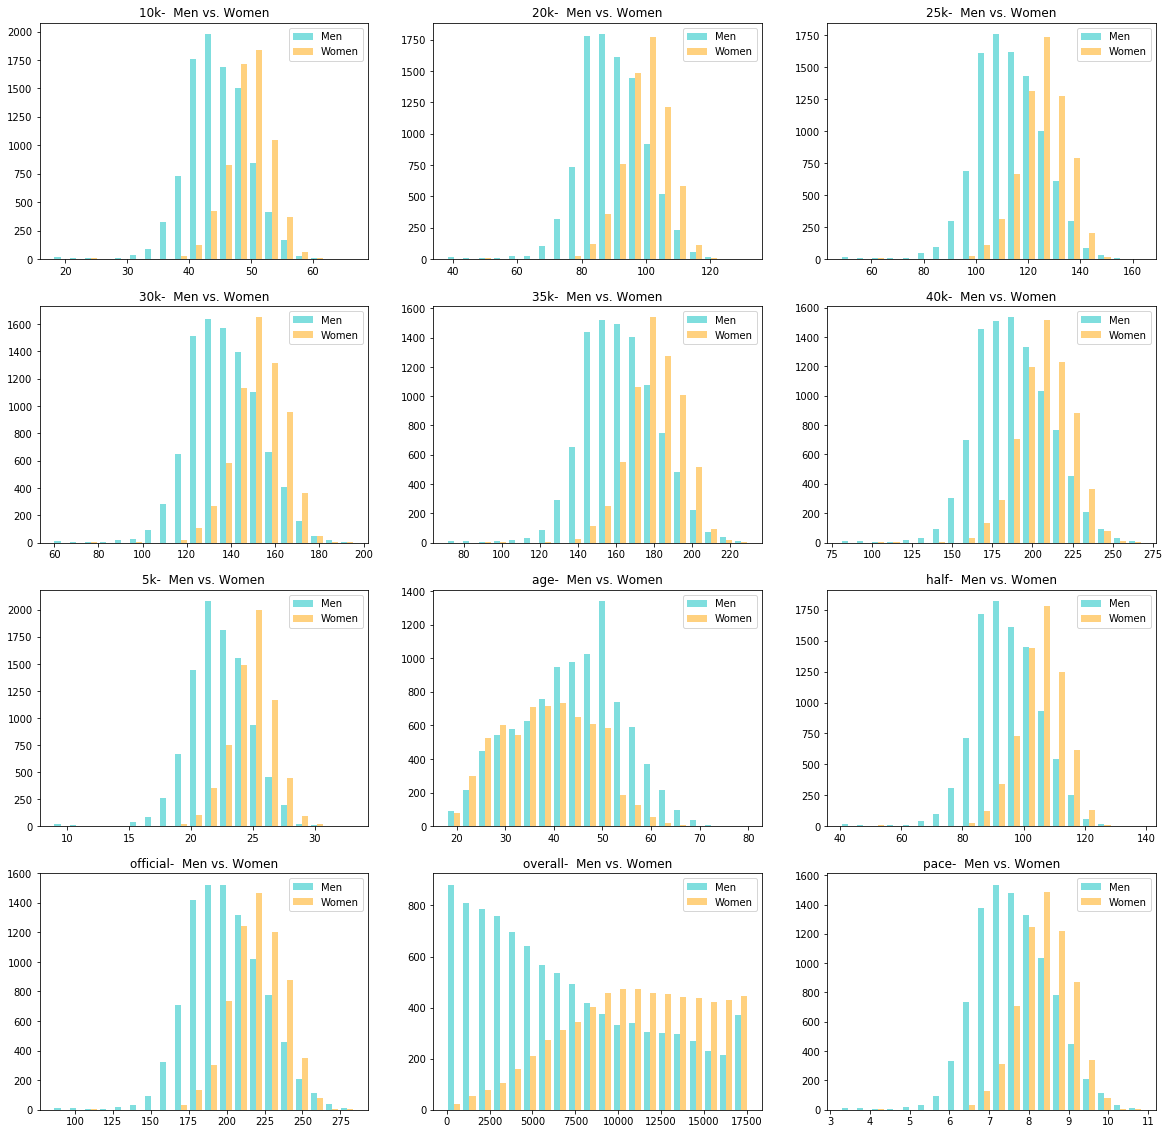

In [64]:
men = df[df['gender_M'] == 1]
women = df[df['gender_F'] == 1]

plt.figure(figsize=(20,20))

for idx, col in enumerate(cols_to_norm):
    plt.subplot(4, 3, idx + 1)
    plt.hist([men[col], women[col]], bins=20, alpha=0.5, color=['c', 'orange'], label=['Men', 'Women'])
    plt.legend()
    plt.title(col + '-  Men vs. Women')

plt.show()

## K-Means

### 2 clusters

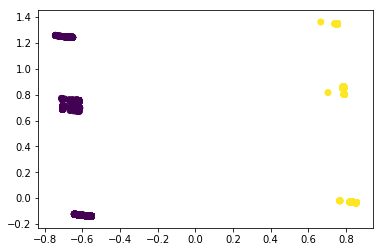

In [5]:
pca_2 = PCA(2).fit_transform(df)
kmeans_2_pred = KMeans(n_clusters=2, random_state=10).fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=kmeans_2_pred)
plt.show()

### 4 clusters

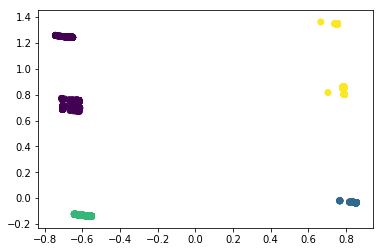

In [6]:
kmeans_4_pred = KMeans(n_clusters=4, random_state=10).fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=kmeans_4_pred)
plt.show()

### 6 clusters

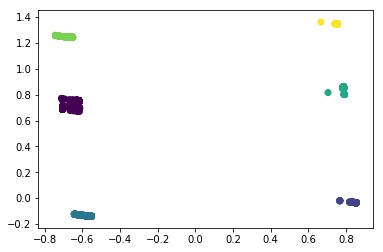

In [7]:
kmeans_6_pred = KMeans(n_clusters=6, random_state=10).fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=kmeans_6_pred)
plt.show()

## Mini-Batch K-Means

### 2 clusters

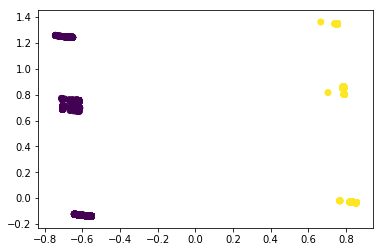

In [8]:
minibatchkmeans = MiniBatchKMeans(init='random', n_clusters=2, batch_size=200)
minibatch_2_pred = minibatchkmeans.fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=minibatch_2_pred)
plt.show()

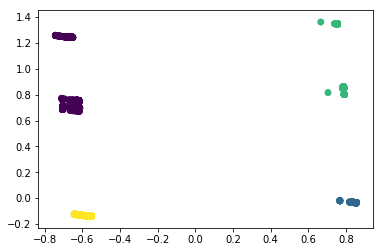

In [9]:
minibatchkmeans = MiniBatchKMeans(init='random', n_clusters=4, batch_size=200)
minibatch_4_pred = minibatchkmeans.fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=minibatch_4_pred)
plt.show()

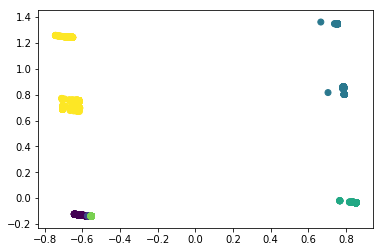

In [10]:
minibatchkmeans = MiniBatchKMeans(init='random', n_clusters=6, batch_size=200)
minibatch_6_pred = minibatchkmeans.fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=minibatch_6_pred)
plt.show()

In [11]:
# how to determine which datapoints lie in which cluster, after PCA?

## Mean-Shift

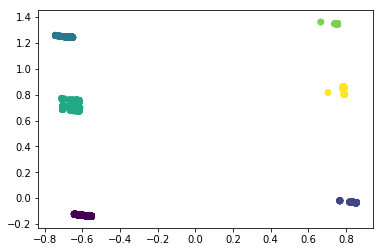

In [12]:
# Derive bandwidth # based on distances among datapoints
bandwidth = estimate_bandwidth(pca_2, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_pred = ms.fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=ms_pred)
plt.show()

In [68]:
df['kmeans_6_pred'] = kmeans_6_pred

cluster_1 = df[df['kmeans_6_pred'] == 0]
cluster_2 = df[df['kmeans_6_pred'] == 1]
cluster_3 = df[df['kmeans_6_pred'] == 2]
cluster_4 = df[df['kmeans_6_pred'] == 3]
cluster_5 = df[df['kmeans_6_pred'] == 4]
cluster_6 = df[df['kmeans_6_pred'] == 5]
all_clusters = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6]

for idx, cluster in enumerate(all_clusters):
    print('*** Cluster #', idx + 1, 'Means ***')
    print(cluster.mean())
    print('\n')

# TODO:
# use not normalized data for means, but use normalized data for actual clustering
# bar plot for each cluster for each feature (grouped by feature)

*** Cluster # 1 Means ***
10k                       43.558668
20k                       87.888329
25k                      110.698512
30k                      134.937128
35k                      160.309974
40k                      186.263133
5k                        21.822533
age                       45.537859
half                      92.762010
official                 197.732167
overall                 6659.770235
pace                       7.549399
continent_Africa           0.060052
continent_Asia             0.402089
continent_Europe           0.000000
continent_N. America       0.000000
continent_Oceania          0.167102
continent_S. America       0.370757
gender_F                   0.000000
gender_M                   1.000000
kmeans_6_pred              0.000000
dtype: float64


*** Cluster # 2 Means ***
10k                        49.640602
20k                        99.917089
25k                       125.599551
30k                       152.490847
35k                       1

In [ ]:
# How to visualize anything beyond PCA 2?
# Better way than above to figure out what each group looks like?
# Normalized data necessary?